 Cart Pole

In [ ]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
# creating the offline dataset 

def collect_dataset(num_episodes=100):
    """
    Collects an offline dataset of transitions from the CartPole-v1 environment
    using a sub optimal behaviour policy.
    """
    env = gym.make("CartPole-v1")
    dataset = []
 # introduce the pole angle policy:

    def deterministic_policy(obs):
        return 0 if obs[2] < 0 else 1
# behavioural policy that uses 50% the deterministic policy and 50% the uniform random policy

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        while not (done or truncated):
            
            if np.random.rand() < 0.5:
                action = np.random.randint(0, 2)
            else:
                action = deterministic_policy(obs)

            next_obs, reward, done, truncated, _ = env.step(action)
            dataset.append((obs, action, reward, next_obs, done or truncated))
            obs = next_obs
    env.close()
    return dataset

#store the offline dataset

offline_dataset = collect_dataset()
print(f"Collected {len(offline_dataset)} transitions for offline learning.")

#initialise the mlp

def zero_initialize_mlp(state_dim):
    """
    Creates an MLPRegressor with default hidden_layer_sizes=(100,),
    sets max_iter=500 for real training, does a dummy fit,
    then forces all weights & biases to zero.
    """
    # default: one hidden layer of 100 units
    
    model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    # dummy fit
    
    dummy_X = np.zeros((1, state_dim))
    model.fit(dummy_X, [0.0])
    # force the weights and the intercepts to zero
    
    for i in range(len(model.coefs_)):
        model.coefs_[i] = np.zeros_like(model.coefs_[i])
    for i in range(len(model.intercepts_)):
        model.intercepts_[i] = np.zeros_like(model.intercepts_[i])
    return model


In [ ]:

# implementation of the fitted Q-Iteration with separate models for each action

def fitted_q_iteration_separate(dataset, state_dim, action_dim, gamma_values, num_iterations=20):
    """
    FQI with separate MLP models per action. Zero-initializes each model, then runs 20 iterations
    of Q-updates for each gamma in gamma_values.

    Returns a dict mapping each gamma -> list of length num_iterations, where each element
    is a dict {action: model} representing the Q-function at that iteration.
    """
    states, actions, rewards, next_states, dones = zip(*dataset)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones).astype(int)  # 1 if done, else 0

    # dictionary to store Q-models for each gamma
    
    all_models = {gamma: [] for gamma in gamma_values}

    for gamma in gamma_values:
        print(f"\nTraining FQI (separate models) for γ={gamma}")
        # initialise a one zero-MLP per action
        
        models_per_action = {a: zero_initialize_mlp(state_dim) for a in range(action_dim)}
        # store the 0 iteration 
        
        all_models[gamma].append(deepcopy(models_per_action))
        
        for it in range(1, num_iterations):
            new_models = {}

            # precompute Q(s', a') for each next state & action using current models
            # shape: (N, action_dim)
            
            q_next_all = np.zeros((len(states), action_dim))
            for a in range(action_dim):
                # predict Q(s', a') for each next state
                
                q_next_all[:, a] = models_per_action[a].predict(next_states)

            # do the maximum over all actions
            
            max_q_next = np.max(q_next_all, axis=1)

            for a in range(action_dim):
                # filter the transitions where action == a
                
                mask = (actions == a)
                if not np.any(mask):
                    new_models[a] = deepcopy(models_per_action[a])
                    continue

                # calculate the td targets: r + gamma * max Q(s', .) * (1 - done)
                targets = rewards[mask] + gamma * max_q_next[mask] * (1 - dones[mask])

                # create a new zero-MLP
                
                new_model = zero_initialize_mlp(state_dim)
                # fit it with the data
                
                new_model.fit(states[mask], targets)
                new_models[a] = new_model

            # store iteration
            
            all_models[gamma].append(deepcopy(new_models))
            models_per_action = new_models
            print(f"γ={gamma}, Iteration {it} completed")

    return all_models


In [ ]:
# the discounted policy evaluation

def evaluate_policy(models_per_action, gamma, num_episodes=1000):
    """
    Evaluates a policy (given by separate MLP models for each action)
    over num_episodes, using discounted returns with discount factor gamma.
    """
    env = gym.make("CartPole-v1")
    returns = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        total_return = 0.0
        discount = 1.0

        while not (done or truncated):
            # compute the Q-values for each action
            
            q_values = [models_per_action[a].predict(obs.reshape(1, -1))[0] for a in range(env.action_space.n)]
            action = np.argmax(q_values)

            next_obs, reward, done, truncated, _ = env.step(action)
            total_return += discount * reward
            discount *= gamma
            obs = next_obs

        returns.append(total_return)

    env.close()
    return np.mean(returns)


Collected 4044 transitions for offline learning.

Training FQI (separate models) for γ=0.95
γ=0.95, Iteration 1 completed
γ=0.95, Iteration 2 completed
γ=0.95, Iteration 3 completed
γ=0.95, Iteration 4 completed
γ=0.95, Iteration 5 completed
γ=0.95, Iteration 6 completed
γ=0.95, Iteration 7 completed
γ=0.95, Iteration 8 completed
γ=0.95, Iteration 9 completed
γ=0.95, Iteration 10 completed
γ=0.95, Iteration 11 completed
γ=0.95, Iteration 12 completed
γ=0.95, Iteration 13 completed
γ=0.95, Iteration 14 completed
γ=0.95, Iteration 15 completed
γ=0.95, Iteration 16 completed
γ=0.95, Iteration 17 completed
γ=0.95, Iteration 18 completed
γ=0.95, Iteration 19 completed

Training FQI (separate models) for γ=0.99
γ=0.99, Iteration 1 completed
γ=0.99, Iteration 2 completed
γ=0.99, Iteration 3 completed
γ=0.99, Iteration 4 completed
γ=0.99, Iteration 5 completed
γ=0.99, Iteration 6 completed
γ=0.99, Iteration 7 completed
γ=0.99, Iteration 8 completed
γ=0.99, Iteration 9 completed
γ=0.99, Iterati

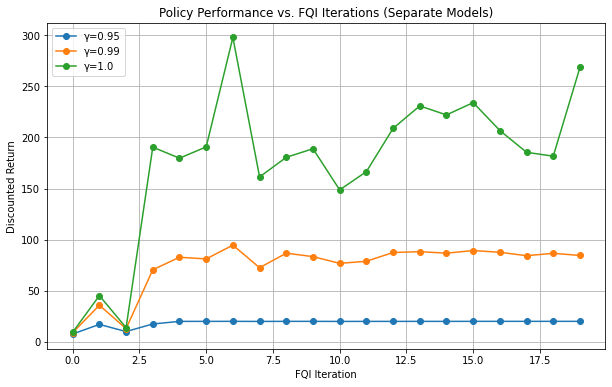

In [2]:
# plot the returns against the iterations

if __name__ == "__main__":
    # 3 discount factors, with 20 iterations for each
    
    GAMMA_VALUES = [0.95, 0.99, 1.0]
    NUM_ITERATIONS = 20

    # create environment for dimensions
    
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    env.close()

    # train Q-models separately for each gamma
    
    all_models = fitted_q_iteration_separate(
        offline_dataset,
        state_dim,
        action_dim,
        gamma_values=GAMMA_VALUES,
        num_iterations=NUM_ITERATIONS
    )

    # evaluate & plot the results
    
    results = {g: [] for g in GAMMA_VALUES}
    for g in GAMMA_VALUES:
        print(f"\nEvaluating γ={g}")
        for it, models in enumerate(all_models[g]):
            avg_return = evaluate_policy(models, g, num_episodes=1000)
            results[g].append(avg_return)
            print(f"Iteration {it}: Avg Return = {avg_return:.2f}")

    # the final plot for discounted factors
    
    plt.figure(figsize=(10, 6))
    for g in GAMMA_VALUES:
        plt.plot(range(NUM_ITERATIONS), results[g], marker='o', label=f'γ={g}')
    plt.xlabel("FQI Iteration")
    plt.ylabel("Discounted Return")
    plt.title("Policy Performance vs. FQI Iterations (Separate Models)")
    plt.legend()
    plt.grid(True)
    plt.show()



Evaluating UNDISCOUNTED returns for γ=0.95
Iteration 0: Avg Undiscounted Return = 9.33
Iteration 1: Avg Undiscounted Return = 45.35
Iteration 2: Avg Undiscounted Return = 13.80
Iteration 3: Avg Undiscounted Return = 52.49
Iteration 4: Avg Undiscounted Return = 155.82
Iteration 5: Avg Undiscounted Return = 175.70
Iteration 6: Avg Undiscounted Return = 248.89
Iteration 7: Avg Undiscounted Return = 140.50
Iteration 8: Avg Undiscounted Return = 195.60
Iteration 9: Avg Undiscounted Return = 193.01
Iteration 10: Avg Undiscounted Return = 157.57
Iteration 11: Avg Undiscounted Return = 162.22
Iteration 12: Avg Undiscounted Return = 159.11
Iteration 13: Avg Undiscounted Return = 216.81
Iteration 14: Avg Undiscounted Return = 176.86
Iteration 15: Avg Undiscounted Return = 202.96
Iteration 16: Avg Undiscounted Return = 200.37
Iteration 17: Avg Undiscounted Return = 197.85
Iteration 18: Avg Undiscounted Return = 209.47
Iteration 19: Avg Undiscounted Return = 210.27

Evaluating UNDISCOUNTED return

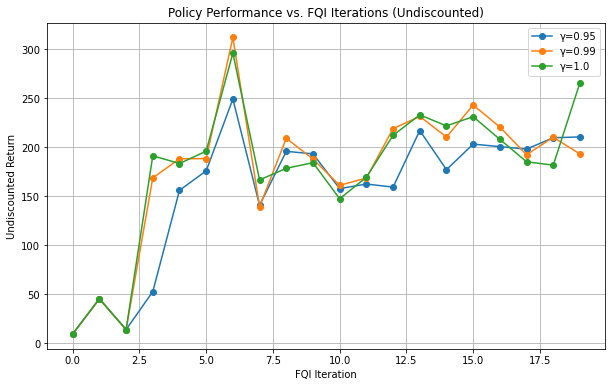

In [3]:
#evaluate the undiscounted returns and plot them

def evaluate_policy_undiscounted(models_per_action, num_episodes=1000):
    """
    Evaluates a policy (given by separate MLP models per action)
    by summing rewards with NO discounting.
    """
    env = gym.make("CartPole-v1")
    returns = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        total_return = 0.0

        while not (done or truncated):
            q_values = [models_per_action[a].predict(obs.reshape(1, -1))[0]
                        for a in range(env.action_space.n)]
            action = int(np.argmax(q_values))

            obs, reward, done, truncated, _ = env.step(action)
            total_return += reward  # This is the line that involves no discounting

        returns.append(total_return)

    env.close()
    return np.mean(returns)


# evaluate the same policies as before, but for UNDISCOUNTED returns

results_undisc = {g: [] for g in GAMMA_VALUES}

for g in GAMMA_VALUES:
    print(f"\nEvaluating UNDISCOUNTED returns for γ={g}")
    for it, models in enumerate(all_models[g]):
        avg_return_undisc = evaluate_policy_undiscounted(models, num_episodes=1000)
        results_undisc[g].append(avg_return_undisc)
        print(f"Iteration {it}: Avg Undiscounted Return = {avg_return_undisc:.2f}")

#plot the undiscounted results in a separate figure

plt.figure(figsize=(10, 6))
for g in GAMMA_VALUES:
    plt.plot(range(NUM_ITERATIONS), results_undisc[g], marker='o', label=f'γ={g}')
plt.xlabel("FQI Iteration")
plt.ylabel("Undiscounted Return")
plt.title("Policy Performance vs. FQI Iterations (Undiscounted)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
#function the evaluate the baseline behaviour of the policy

def evaluate_behaviour_policy(env, num_episodes=1000):
    returns = []
    for _ in range(num_episodes):
        obs, *_ = env.reset()
        done = False
        total_return = 0.0
        while not done:
            # 50% random, 50% deterministic
            
            if np.random.rand() < 0.5:
                action = np.random.randint(0, 2)
            else:
                action = 0 if obs[2] < 0 else 1
            # unpack all five values returned by env.step()
            obs, reward, done, truncated, _ = env.step(action)
            # treat the episode as done if either flag is true
            
            done = done or truncated
            total_return += reward
        returns.append(total_return)
    return np.mean(returns)


env = gym.make("CartPole-v1")
baseline_return = evaluate_behavior_policy(env, num_episodes=1000)
print(f"Baseline behavior policy average return: {baseline_return:.2f}")
env.close()



Baseline behavior policy average return: 41.65


## Analysis

We have generated return plots for both discounted and undiscounted returns for each of the 60 policies. In each plot, a separate line represents a different γ value, and each point on a line corresponds to the return (discounted or undiscounted) for a specific iteration.

The results in the discounted graph are consistent with expectations: the average return is higher for higher γ values. Specifically, for γ=0.95, the expected return converges to approximately 20 within fewer than 5 iterations. For γ=0.99, the expected return eventually falls between 80 and 90 after only a few iterations—showing an improvement over γ=0.95, but not a dramatic one. For γ=1.0, the return values are considerably higher and more volatile, with maximum values reaching around 300 and several regions where returns range between 200 and 250. However, this is somewhat lower than anticipated, as we did not observe values approaching 500, which is expected given that our chosen strategy is sub-optimal. Even so, γ=1.0 dominates, indicating that when you do not diminish future rewards at all, the policy finds a strategy that maximizes the long-horizon reward. This makes sense in CartPole, where longevity directly translates to higher total reward.

For the undiscounted return plot, we again see one line per γ value, with each point representing the total reward at a given iteration. Unlike the discounted results, the lines here occasionally cross and exhibit more pronounced spikes. For example, γ=0.95 might briefly surpass γ=0.99, γ=1.0, and we see peaks around 200–300 that later dip back toward 100–150. This behaviour arises because the policies trained under discounted objectives— re now evaluated by a purely cumulative metric, which can yield unexpected rankings of performance. While γ=1.0 may still reach high values, there is no consistent dominance as in the discounted case, and the overall volatility is higher. These variations are normal when measuring undiscounted returns for policies optimized with different 
γ. They do not indicate a coding error; rather, they highlight that each policy’s training focus does not always align perfectly with a plain-sum reward evaluation.









## Extended Analysis and Enhancements

While this code includes an additional plot for the undiscounted return values to contrast with the discounted return values, it also evaluates the baseline, untrained behaviour policy to establish a performance benchmark. The baseline behaviour policy achieves an average of approximately 40 over 1,000 episodes. This result provides a useful benchmark for evaluating the performance of the learned policies under Fitted Q-Iteration. Since the behaviour policy consists of a 50% random and 50% deterministic approach, it is expected to perform sub-optimally compared to an optimized policy.

From our previous policy evaluation results, we observed that the learned policies significantly outperform the behavior policy, especially for higher values of γ. For instance, in the discounted evaluation, policies trained with γ=1.0 reached returns well above 200, while the behavior policy only reached 40.44 on average. This confirms that the FQI process successfully learned a superior strategy for balancing the pole, demonstrating the advantage of reinforcement learning over simple heuristics or random action selection.

Additionally, this baseline provides insight into the effectiveness of the dataset used for offline learning. Since FQI was trained on transitions generated from this behaviour policy, the fact that learned policies outperform it suggests that the offline learning process was successful in extracting better strategies from sub-optimal data. However, if the learned policies had not significantly outperformed this baseline, it could indicate issues such as insufficient dataset quality, poor convergence, or ineffective value function approximation.

Finally, the code includes prints of the value of the average returns at each iteration for each of the γ values.